<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/kernel_regression_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nadaraya-Watson kernel regression in 1d using attention


We show how to interpret kernel regression as an attention mechanism.
Based on sec 10.2 of http://d2l.ai/chapter_attention-mechanisms/nadaraya-waston.html




In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(seed=1)
import math
import collections

try:
    import torch
except ModuleNotFoundError:
    %pip install torch
    import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
try:
    import d2l
except ModuleNotFoundError:
    %pip install torchvision
    import d2l

# Data

In [2]:
torch.manual_seed(0)
n_train = 50  # No. of training examples
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # Training inputs


def f(x):
    return 2 * torch.sin(x) + x**0.8


y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # Training outputs
x_test = torch.arange(0, 5, 0.1)  # Testing examples
y_truth = f(x_test)  # Ground-truth outputs for the testing examples
n_test = len(x_test)  # No. of testing examples
n_test

50

# Constant baseline

As a baseline, we use the empirical mean of y.

In [3]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], "x", "y", legend=["Truth", "Pred"], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, "o", alpha=0.5);

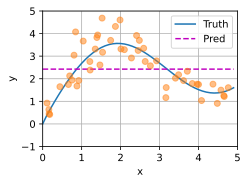

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

# Kernel regression

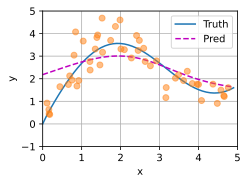

In [5]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the
# same testing inputs (i.e., same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = nn.functional.softmax(-((X_repeat - x_train) ** 2) / 2, dim=1)
# Each element of `y_hat` is weighted average of values, where weights are
# attention weights
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)
plt.savefig("kernelRegrAttenPlot.pdf", dpi=300)

We can visualize the kernel matrix to see which inputs are used to predict each output.

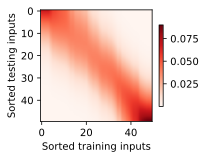

In [6]:
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0), xlabel="Sorted training inputs", ylabel="Sorted testing inputs"
)
plt.savefig("kernelRegrAttenMat.pdf", dpi=300)

# Implementation using learned attention

As an illustration of how to learn attention kernels, we make the bandwidth parameter adjustable, so we can optimize it by backprop.


The implementation uses batch matrix multiplication (torch.bmm).
This is defined as follows. Suppose the first batch contains n matrix Xi of size a x b, and the second batch contains n matrix Yi of size b x c. Then the output will have size (n, a, c).



In [7]:
# 2 batches of weights over the 10 data points
weights = torch.ones((2, 10)) * 0.1
weights = weights.unsqueeze(1)
print(weights.shape)  # (2,1,10)

# 2 batches of 10 scalar data points
values = torch.arange(20.0).reshape((2, 10))
values = values.unsqueeze(-1)
print(values.shape)  # (2,10,1)

Y = torch.bmm(weights, values)
print(Y.shape)
print(Y)

torch.Size([2, 1, 10])
torch.Size([2, 10, 1])
torch.Size([2, 1, 1])
tensor([[[ 4.5000]],

        [[14.5000]]])


In [8]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # Shape of the output `queries` and `attention_weights`:
        # (no. of queries, no. of key-value pairs)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-(((queries - keys) * self.w) ** 2) / 2, dim=1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

To apply attention to kernel regression, we make a batch of size $N$, where $N$ is the number of training points. In batch $i$, the query is the $i$'th training point we are truying to predict, the keys are all the other inputs $x_{-i}$ and the values are all the other outpouts $y_{-i}$.



In [9]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the
# same training inputs
X_tile = x_train.repeat((n_train, 1))
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the
# same training outputs
Y_tile = y_train.repeat((n_train, 1))
# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

print([x_train.shape, X_tile.shape, keys.shape, values.shape])

[torch.Size([50]), torch.Size([50, 50]), torch.Size([50, 49]), torch.Size([50, 49])]


Train using SGD.

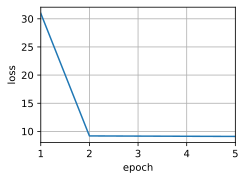

In [10]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel="epoch", ylabel="loss", xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f"epoch {epoch + 1}, loss {float(l.sum()):.6f}")
    animator.add(epoch + 1, float(l.sum()))

# Results of training

Not suprisignly, fitting the hyper-parameter 'w' (the bandwidth of the kernel) results in overfitting, as we show below. However, for parametric attention, this is less likely to occur.


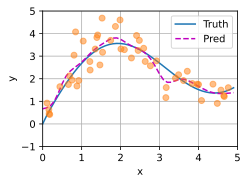

In [11]:
# Shape of `keys`: (`n_test`, `n_train`), where each column contains the same
# training inputs (i.e., same keys)
keys = x_train.repeat((n_test, 1))
# Shape of `value`: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

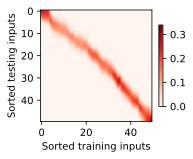

In [12]:
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0), xlabel="Sorted training inputs", ylabel="Sorted testing inputs"
)

In [13]:
print(net.w)

Parameter containing:
tensor([4.5967], requires_grad=True)
